# ESPIDAM SIR Age-Structured Example

*Authors: Sebastiaan Weytjens, Pieter Libin, Niel Hens*

### Age-Structured SIR: Adding Contact Behaviour

<img src="age_sir_model.png" alt="The diagram of an age-structured SIR model." style="width:400px;"/>

Assume the following contact matrix, which contains contact between children and adults. Rows and columns 0 and 1 represent children and adults, respectively. For example, $C_{0 1}$ are the contacts of children with adults, which is 9 in this case [1]. 



$C=\left(\begin{array}{cc}18 & 9 \\ 3 & 12\end{array}\right)$

Consequently, we modify the rate (i.e., the force of infection) between $S$ and $I$ as follows:

$
-\beta \cdot \sum_j C_{i j} \cdot I_j / N_j
$

The ODE equations for the age structured SIR model become the following: 

$
\begin{aligned}
\frac{{dS_i}}{{dt}} &= -\beta \cdot S_i \cdot \sum_j C_{i j} \cdot I_j / N_j \\
\frac{{dI_i}}{{dt}} &= \beta \cdot S_i \cdot \sum_j C_{i j} \cdot I_j / N_j - \gamma \cdot I_i\\
\frac{{dR_i}}{{dt}} &= \gamma \cdot I_i
\end{aligned}
$

[1]: SIR infectious disease model with age classes: https://sherrytowers.com/2012/12/11/sir-model-with-age-classes/

#### Dependencies

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sir_helpers import *
import math
from numpy.linalg import eig

#### Model Description

We will start with the model description. We gave you head start by filling in the compartments, the contact matrix and the initial compartment values. Complete the force of infection and the rate between $I$ and $R$.

In [2]:
# Compartments
compartments = {
    "S_c": [],
    "I_c": [],
    "R_c": [],
    "S_a": [],
    "I_a": [],
    "R_a": []
}

# Contact Matrix
def contacts(i, j):
    #Note that it is not the most efficient way to return a matrix like this, but we focus here on clarity
    contact_matrix = [[18, 9], [3, 12]]
    return contact_matrix[i][j]

#Transition rates
#Ns are populations sizes of all age classes ac_i is the age class i (as shown in the aforementioned formulas), acs is the number of age classes
def foi(i, params, Ns, ac_i, acs):
    foi_value = 0

    #SOLUTION: FOI calculation
    for ac_j in range(acs):
        foi_value += contacts(ac_i, ac_j) * i[ac_j] * params["beta"] / Ns[ac_j]

    return foi_value

def i_r(params):
    return params["gamma"]

def initialise_modelstate(modelstate, seeds, N_c, N_a):
    modelstate["S_c"] = [N_c - seeds]
    modelstate["I_c"] = [seeds]
    modelstate["R_c"] = [0]

    modelstate["S_a"] = [N_a - seeds]
    modelstate["I_a"] = [seeds]
    modelstate["R_a"] = [0]

    return modelstate

#### Contact restrictions

How would you implement working from home and closing schools? Complete the contact functions for those scenarios below.

In [3]:
def contacts_working_from_home(i, j):
    #SOLUTION: We reduced the contacts between adults to 1.
    contact_matrix = [[18, 9], [3, 1]]
    return contact_matrix[i][j]

def contacts_schools_closed(i, j):
    #SOLUTION: We reduced the contacts between children to 0.
    contact_matrix = [[0, 9], [3, 12]]
    return contact_matrix[i][j]

#### Solvers for the model

Next, we will use ODEs and the Binomial Chain to simulate our model. Complete the ode_system and binom_solver functions.

In [4]:
# ODE Solver

def ode_system(y0, t, parameters): 
    params = parameters["disease_params"]
    Ns = parameters["Ns"]

    s_c, i_c, r_c, s_a, i_a, r_a = y0
    ds_c, di_c, dr_c, ds_a, di_a, dr_a = 0, 0, 0, 0, 0, 0

    #SOLUTION: Calculate the new individuals for each compartment for children and adults
    foi_c = foi([i_c, i_a], params, Ns, 0, 2)
    ds_c += - foi_c * s_c
    di_c += foi_c * s_c - i_r(params) * i_c
    dr_c += i_r(params) * i_c

    foi_a = foi([i_c, i_a], params, Ns, 1, 2)
    ds_a += - foi_a * s_a
    di_a += foi_a * s_a - i_r(params) * i_a
    dr_a += i_r(params) * i_a  

    return ds_c, di_c, dr_c, ds_a, di_a, dr_a      

def ode_solver(model_state, end_t, params, Ns):
    all_parameters = {
        "disease_params": params,
        "Ns": Ns
    }
    # Initial conditions (modelstates, timesteps)   
    y0 = (model_state["S_c"][0], model_state["I_c"][0], model_state["R_c"][0], model_state["S_a"][0], model_state["I_a"][0], model_state["R_a"][0])
    t = np.linspace(0, end_t, end_t)
    
    # Solving the ODE system
    ret = odeint(ode_system, y0, t, args=(all_parameters,))
    s_c, i_c, r_c, s_a, i_a, r_a = ret.T

    new_modelstate = {
        "S_c": list(s_c),
        "I_c": list(i_c),
        "R_c": list(r_c),
        "S_a": list(s_a),
        "I_a": list(i_a),
        "R_a": list(r_a)
    }

    return new_modelstate

# Binomial Chain solver

def binom_solver(model_state, end_t, params, Ns, iterations):
    model_states = {
        "S_c": [],
        "I_c": [],
        "R_c": [],
        "S_a": [],
        "I_a": [],
        "R_a": []
    }
    #For every iteration we simulate a trajectory
    for _ in range(iterations):
        s_c = [model_state["S_c"][0]]
        i_c = [model_state["I_c"][0]]
        r_c = [model_state["R_c"][0]]
        s_a = [model_state["S_a"][0]]
        i_a = [model_state["I_a"][0]]
        r_a = [model_state["R_a"][0]]

        #SOLUTION: Calculate the new individuals for each compartment for children and adults at each day
        #we simulate 10 steps per day to get a more accurate approximation
        for t in range(1, end_t * 10):
            i_new_c = np.random.binomial(s_c[t-1], rate_to_p(foi([i_c[t-1], i_a[t-1]], params, Ns, 0, 2), 1/10))
            r_new_c = np.random.binomial(i_c[t-1],rate_to_p(i_r(params), 1/10))

            s_c.append(s_c[t-1] - i_new_c)
            i_c.append(i_c[t-1] + i_new_c - r_new_c)
            r_c.append(r_c[t-1] + r_new_c)

            i_new_a = np.random.binomial(s_a[t-1],rate_to_p(foi([i_c[t-1], i_a[t-1]], params, Ns, 1, 2), 1/10))
            r_new_a = np.random.binomial(i_a[t-1],rate_to_p(i_r(params), 1/10))

            s_a.append(s_a[t-1] - i_new_a)
            i_a.append(i_a[t-1] + i_new_a - r_new_a)
            r_a.append(r_a[t-1] + r_new_a)   

        #Appending the iteration trajectories to the results
        indices = [index for index in range(0, end_t * 10, 10)]
        model_states["S_c"].append([s_c[index] for index in indices])
        model_states["I_c"].append([i_c[index] for index in indices])
        model_states["R_c"].append([r_c[index] for index in indices])
        model_states["S_a"].append([s_a[index] for index in indices])
        model_states["I_a"].append([i_a[index] for index in indices])
        model_states["R_a"].append([r_a[index] for index in indices])

    return model_states

#### Model Parameters

If you implemented everything correctly, you can use the parameters below to simulate your age-structured SIR model. Note that $\beta$ is calculated using $\gamma$, $R_0$ and the spectral radius of the normalised contact matrix.

In [5]:
N = 1000000
N_c = 0.25 * N #total population of children
N_a = 0.75 * N #total population of adults
seeds = 1 #initial number of infected individuals

gamma = 1/7 #recovery rate
R0 = 3 #basic reproduction number
f = [0.25, 0.75] # fraction of children and adults
m = np.array([[18*f[0]/f[0], 9*f[0]/f[1]], [3*f[1]/f[0], 12*f[1]/f[1]]]) #normalised contact matrix
spectral_radius = max(eig(m)[0]) #spectral radius of the contact matrix

params = {
    "beta": R0 * gamma / spectral_radius, #transmission rate
    "gamma": gamma, #recovery rate
}

end_t = 150 #days to simulate

##### Deterministic simulation

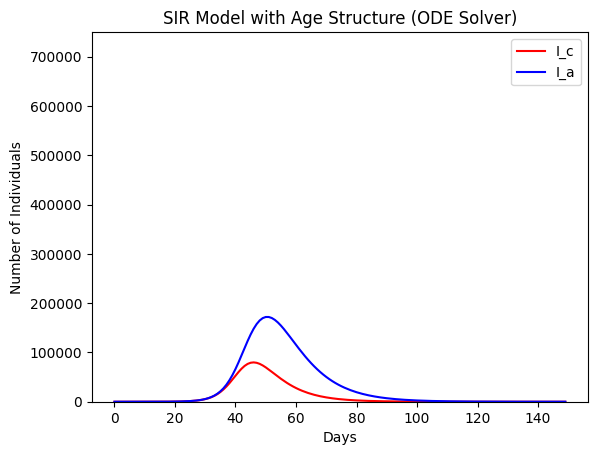

In [6]:
modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_age(results, "SIR Model with Age Structure (ODE Solver)", max(N_c, N_a))

##### Plotting stochastic results

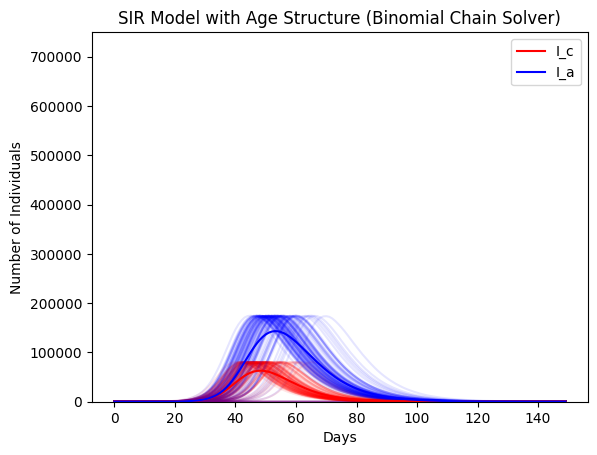

In [7]:
modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = binom_solver(modelstate, end_t, params, [N_c, N_a], 100)

plot_binom_age(results, "SIR Model with Age Structure (Binomial Chain Solver)", max(N_c, N_a))

#### Working from Home

Adjust your model so that individuals are working from home by using the contact matrix you created before. Do a deterministic simulation. Did working from home affect the number of infections?

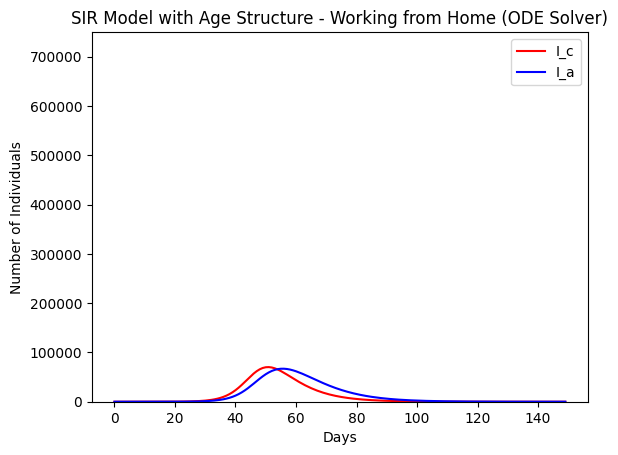

In [8]:
#SOLUTION: Perform a deterministic simulation with the working from home scenario
#We modify the force of infection to use the working_from_home matrix
def foi(i, params, Ns, ac_i, acs):
    foi_value = 0

    for ac_j in range(acs):
        #We use the contacts_working_from_home function here
        foi_value += contacts_working_from_home(ac_i, ac_j) * i[ac_j] * params["beta"] / Ns[ac_j]

    return foi_value

modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_age(results, "SIR Model with Age Structure - Working from Home (ODE Solver)", max(N_c, N_a))